In [1]:
from brian2 import *
import csv
import random
import os, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from scipy.spatial import distance

WARNING    /home/ahuertas/anaconda3/envs/brian2/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
 [py.warnings]


In [2]:
# Interesting links:

# http://www.maths.dit.ie/~johnbutler/Izhikevich/IzhikevichModel.html#Thalamo-cortical
# https://www.izhikevich.org/publications/spikes.pdf
# https://github.com/brian-team/brian2/issues/809
# http://neuralensemble.org/docs/PyNN/reference/neuronmodels.html

In [3]:
min_range_V = 5
max_range_V = 10

In [4]:
list_attack_generation = ["FLO", "SCA"]

### Methods for csv export

In [5]:
def append_to_csv_file(filename, line):
    # Update the attack file
    with open(filename, 'a') as csvFile:
        writer = csv.writer(csvFile, delimiter=';')
        writer.writerow(line)

def dump_simulation_data_to_csv(attack, test, n_attacks, n_neurons, attacked_neurons, coord_attack, stim_value, n_exec, vIncrement, paramI, monitor, filename):
    mon_trains = monitor.spike_trains()
    
    for neuron in mon_trains.keys():
        for time_delta in mon_trains[neuron]:
            append_to_csv_file(filename, [attack, test, n_attacks, n_neurons, attacked_neurons, coord_attack, stim_value, n_exec, str(vIncrement), str(paramI), round(time_delta/ms, 1), neuron])

def list_neurons_to_string(list_neurons):
    result = ""
    for neuron in list_neurons:
        result += str(neuron)+"-"
        
    return result[:-1]

### General variables and constants

In [6]:
list_coordinates_optimal_path = [[0,0], [1,0], [1,1], [1,2], [0,2], [0,3], [0,4], [0,5], [1,5], [2,5], 
                                 [2,4], [2,3], [3,3], [3,2], [3,1], [3,0], [4,0], [5,0], [6,0], [6,1], 
                                 [6,2], [5,2], [5,3], [5,4], [5,5], [6,5], [6,6]]

In [7]:
list_coordinates_optimal_path = [[0,0]]

In [8]:
STEP_TIME = 1000*ms
#STEP_TIME = 1000*ms

# STEP_TIME per movement. As there are 27 positions -> 27*STEP_TIME. 
SIMULATION_TIME = (STEP_TIME/ms*len(list_coordinates_optimal_path))*ms

In [9]:
SIMULATION_TIME

1. * second

In [10]:
# Duration of simulation, after STEP_TIME. Divided by the number of neurons
def get_time_steps_sequential(tAttack):
    return trunc(((SIMULATION_TIME-tAttack)/200)/ms)*ms

def get_number_attacks_per_position_sequential(tAttack):
    return STEP_TIME/get_time_steps_sequential(tAttack)

def get_last_instant_attack_sequential(tAttack):
    return tAttack+get_time_steps_sequential(tAttack)*200

In [11]:
get_time_steps_sequential(50*ms)

4. * msecond

In [12]:
get_number_attacks_per_position_sequential(50*ms)

250.0

In [13]:
get_last_instant_attack_sequential(50*ms)

0.85 * second

### Auxiliary methods to translate between coordinates and indexes

In [14]:
def generate_list_random_neurons(nNeurons):
    list_neurons = list(range(0, 200))
    result = []

    for i in range(0, nNeurons):
        index = randint(0, len(list_neurons))
        
        result.append(list_neurons[index])
        del list_neurons[index]
    
    return sorted(result)

#def neurons_list_to_string(listNeurons):

#    printString = "["
#    for item in sorted(listNeurons):
#        printString+=str(item)+","

#    return printString[:-1]+"]"

In [15]:
# Dict that stores the index value of a neuron: 3D coordinate -> numeric index (0-199)
dict_neurons_to_numbers = {}

counter = 0

for i in range(0, 5):
    for j in range(0, 5): 
        for k in range(0, 8): 
            dict_neurons_to_numbers[(i,j,k)] = counter
            counter+=1

In [16]:
dict_neurons_to_numbers

{(0, 0, 0): 0,
 (0, 0, 1): 1,
 (0, 0, 2): 2,
 (0, 0, 3): 3,
 (0, 0, 4): 4,
 (0, 0, 5): 5,
 (0, 0, 6): 6,
 (0, 0, 7): 7,
 (0, 1, 0): 8,
 (0, 1, 1): 9,
 (0, 1, 2): 10,
 (0, 1, 3): 11,
 (0, 1, 4): 12,
 (0, 1, 5): 13,
 (0, 1, 6): 14,
 (0, 1, 7): 15,
 (0, 2, 0): 16,
 (0, 2, 1): 17,
 (0, 2, 2): 18,
 (0, 2, 3): 19,
 (0, 2, 4): 20,
 (0, 2, 5): 21,
 (0, 2, 6): 22,
 (0, 2, 7): 23,
 (0, 3, 0): 24,
 (0, 3, 1): 25,
 (0, 3, 2): 26,
 (0, 3, 3): 27,
 (0, 3, 4): 28,
 (0, 3, 5): 29,
 (0, 3, 6): 30,
 (0, 3, 7): 31,
 (0, 4, 0): 32,
 (0, 4, 1): 33,
 (0, 4, 2): 34,
 (0, 4, 3): 35,
 (0, 4, 4): 36,
 (0, 4, 5): 37,
 (0, 4, 6): 38,
 (0, 4, 7): 39,
 (1, 0, 0): 40,
 (1, 0, 1): 41,
 (1, 0, 2): 42,
 (1, 0, 3): 43,
 (1, 0, 4): 44,
 (1, 0, 5): 45,
 (1, 0, 6): 46,
 (1, 0, 7): 47,
 (1, 1, 0): 48,
 (1, 1, 1): 49,
 (1, 1, 2): 50,
 (1, 1, 3): 51,
 (1, 1, 4): 52,
 (1, 1, 5): 53,
 (1, 1, 6): 54,
 (1, 1, 7): 55,
 (1, 2, 0): 56,
 (1, 2, 1): 57,
 (1, 2, 2): 58,
 (1, 2, 3): 59,
 (1, 2, 4): 60,
 (1, 2, 5): 61,
 (1, 2, 6): 62,
 (

In [17]:
# Dict that stores the instant in which the mouse is in eah position of the optimal path

dict_instant_optimal_path = {}

counter = 0

for coord in list_coordinates_optimal_path:
    dict_instant_optimal_path[(coord[0],coord[1])]= counter
    counter += STEP_TIME/ms     

# List of the instants previously calculated (list values of dict)
list_values = list(dict_instant_optimal_path.values())
list_instant_optimal_path = []

for value in list_values:
    list_instant_optimal_path.append(round(value))

In [18]:
def get_visible_coordinates_by_position(x,y):
    
    coords = [[x-1,y-1], [x-1, y], [x-1,y+1], [x,y-1], [x,y], [x,y+1], [x+1,y-1], [x+1,y], [x+1,y+1]]
    result = []
    
    for n in coords:
        if (0 <= n[0] <= 6) and (0 <= n[1] <= 6):
            result.append(n)
            
    return result

In [19]:
get_visible_coordinates_by_position(3,3)

[[2, 2], [2, 3], [2, 4], [3, 2], [3, 3], [3, 4], [4, 2], [4, 3], [4, 4]]

In [20]:
# Get the neurons indexes that are related to a given maze coordinate
def get_neurons_indexes_by_position(x, y):
    
    coords = [
        [x-2,y-2,0], [x-2,y-2,1], [x-2,y-2,2], [x-2,y-2,3], [x-2,y-2,4], [x-2,y-2,5], [x-2,y-2,6], [x-2,y-2,7],
        [x-2,y-1,0], [x-2,y-1,1], [x-2,y-1,2], [x-2,y-1,3], [x-2,y-1,4], [x-2,y-1,5], [x-2,y-1,6], [x-2,y-1,7],
        [x-2,y,0], [x-2,y,1], [x-2,y,2], [x-2,y,3], [x-2,y,4], [x-2,y,5], [x-2,y,6], [x-2,y,7],
        [x-1,y-2,0], [x-1,y-2,1], [x-1,y-2,2], [x-1,y-2,3], [x-1,y-2,4], [x-1,y-2,5], [x-1,y-2,6], [x-1,y-2,7],
        [x-1,y-1,0], [x-1,y-1,1], [x-1,y-1,2], [x-1,y-1,3], [x-1,y-1,4], [x-1,y-1,5], [x-1,y-1,6], [x-1,y-1,7],
        [x-1,y,0], [x-1,y,1], [x-1,y,2], [x-1,y,3], [x-1,y,4], [x-1,y,5], [x-1,y,6], [x-1,y,7],
        [x,y-2,0], [x,y-2,1], [x,y-2,2], [x,y-2,3], [x,y-2,4], [x,y-2,5], [x,y-2,6], [x,y-2,7],
        [x,y-1,0], [x,y-1,1], [x,y-1,2], [x,y-1,3], [x,y-1,4], [x,y-1,5], [x,y-1,6], [x,y-1,7],
        [x,y,0], [x,y,1], [x,y,2], [x,y,3], [x,y,4], [x,y,5], [x,y,6], [x,y,7],
    ]
    
    coord_result = []
    result = []
    
    for n in coords:
        if (0 <= n[0] <= 4) and (0 <= n[1] <= 4):
            coord_result.append(n)
            
    for coord in coord_result:
        result.append(dict_neurons_to_numbers[(coord[0],coord[1],coord[2])])
        #result.append(str(dict_neurons_to_numbers[(coord[0],coord[1],coord[2])]) + " - [" + str(coord[0]) + "," + str(coord[1]) + "," + str(coord[2]) + "]")
    return result

In [21]:
get_neurons_indexes_by_position(3,3)

[48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151]

In [22]:
def get_related_neurons_visible_positions(x, y):
    # Get the positions visible from the current position
    visible_coords = get_visible_coordinates_by_position(x, y)
    
    # Get the complete list of neurons related to all visible positions
    list_neurons_index = []

    for coord in visible_coords:
        neurons = get_neurons_indexes_by_position(coord[0], coord[1])
        
        for n in neurons:
            list_neurons_index.append(n)
    
    # Remove duplicates in list_neurons_index
    result = []
    
    for n in list_neurons_index:
        if n not in result:
            result.append(n)
            
    return result

In [23]:
get_related_neurons_visible_positions(0,0)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55]

### Auxiliary methods for Brian Simulation

In [24]:
# Print plot for a state monitor
def plot_state_monitor(monitor, neuron):
    plot(monitor.t/ms, monitor.v[neuron]/mV)
    xlabel('Time (ms)')
    ylabel('v');
    
sns.set(style="whitegrid",font_scale=2.5, rc={'figure.figsize':(60,20)})


def seaborn_state_monitor(monitor, neuron): 
    ax = sns.lineplot(monitor.t/ms, monitor.v[neuron]/mV, linewidth=3.0)
    
    '''
    cont = STEP_TIME/ms
    for a in range(0, len(list_coordinates_optimal_path)+1):
        plt.axvline(x=cont*a, color="red")

    ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
    '''
    plt.plot()

In [25]:
### FUNCTIONS TO LOAD DATA FROM EXTERNAL FILES (TOPOLOGY, WEIGHTS, PARAMETERS...) ###

def getSynapsisDataFromFile(filename):
    synapsysData = []
    minWeight = 0
    maxWeight = 0
    
    with open(filename) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=';')
        next(csvReader, None) # skip header
        
        firstRow =  next(csvReader)
        synapsysData.append([int(firstRow[0]), int(firstRow[1]), float(firstRow[2])])
        minWeight = float(firstRow[2])
        maxWeight = float(firstRow[2])
        
        for row in csvReader:
            synapsysData.append([int(row[0]), int(row[1]), float(row[2])])
            
            if minWeight > float(row[2]):
                minWeight = float(row[2])
            if maxWeight < float(row[2]):
                maxWeight = float(row[2])
    
    return synapsysData, minWeight, maxWeight

def loadIzhikevichParamI(fileName):
    with open(fileName, 'r') as reader:
        I = [line.rstrip('\n') for line in reader]
        
        for i in range(0, len(I)):
            I[i] = float(I[i])*mV/ms
        
        return I
    
def load_initial_voltages(fileName):
    with open(fileName, 'r') as reader:
        v = [line.rstrip('\n') for line in reader]
        
        for i in range(0, len(v)):
            v[i] = float(v[i])*mV
        
        return v
    
#I = loadIzhikevichParamI("paramI.txt")


def exportDataStateMonitor(dataStateMon):
    dataStoreStateMon = []
    
    # STATEMON
    # attr (v), time (0-999), neuron (0-199)
    # if execTime == 100ms, len is 1k iterations
    for time in range(0, len(dataStateMon['v'])):
        timeData = []

        for neuron in range(0, len(dataStateMon['v'][time])):
            timeData.append(dataStateMon['v'][time][neuron])
        
        dataStoreStateMon.append(timeData)

     # Result: for each instant, the V of each single neuron
    
    return dataStoreStateMon


def exportDataSpikeMonitor(dataSpikeMon):          
    # SPIKEMON
    # "t": time of each spike during the simulation
    # "i": nb of neuron that spikes, in chronological order. 
    # "count": indicates, for each neuron, the nb of spikes during the simulation

    # Result: array of 2 positions that contains:
    #     0) array where each position has the binome <time instant, nb of neuron>
    #     1) the array "count" with the nb of spikes per neuron
    #
    # Precondition: nb elements in "t" == nb elments in "i"
    
    dataStoreSpikeMon = []
    timeSpikeMon = []
    countSpikeMon = []

    for time in range(0, len(dataSpikeMon['t'])):
        # Each position: <time, nNeuron>
        timeSpikeMon.append([dataSpikeMon['t'][time], dataSpikeMon['i'][time]])
    
    for nSpikes in range(0, len(dataSpikeMon['count'])):
        # Each position: nSpikes
        countSpikeMon.append(dataSpikeMon['count'][nSpikes])
    
    dataStoreSpikeMon = [timeSpikeMon, countSpikeMon]
    
    return dataStoreSpikeMon


def exportAllDataMonitors(stateMons, spikeMons):
    # Generate data to export to CSV (suitable format for later processing)
    dataStateMon1 = exportDataStateMonitor(stateMons[0].get_states(units=False))
    dataStateMon2 = exportDataStateMonitor(stateMons[1].get_states(units=False))
    dataStateMon3 = exportDataStateMonitor(stateMons[2].get_states(units=False))

    dataSpikeMon1 = exportDataSpikeMonitor(spikeMons[0].get_states(units=False))
    dataSpikeMon2 = exportDataSpikeMonitor(spikeMons[1].get_states(units=False))
    dataSpikeMon3 = exportDataSpikeMonitor(spikeMons[2].get_states(units=False))
    
    return [dataStateMon1, dataSpikeMon1, dataStateMon2, dataSpikeMon2, dataStateMon3, dataSpikeMon3]

### FUNCTIONS TO GENERATE RANDOM NUMBER OF NEURONS ###

def generateRandomNeurons(currentNeurons):
    selectedNeurons = []
    
    # Generate random coordinates for the current number of neurons
    for currentRandom in range(0, currentNeurons):

        randNeuron = np.random.randint(0, 200)

        # Avoid duplicates
        while (randNeuron in selectedNeurons):
            randNeuron = np.random.randint(0, 200)

        # Store the selected neuron
        selectedNeurons.append(randNeuron)
        
    return selectedNeurons

    
def generatePairsRandomNeurons(currentNeurons):    
    selectedNeurons = []
    selectedPairsNeurons = []
    
    # Generate random coordinates for the current number of neurons -> pairs of neurons
    for currentRandom in range(0, currentNeurons):
        # Neuron 1 of the pair
        randNeuron1 = np.random.randint(0, 200)

        # Avoid duplicates for neuron 1
        while (randNeuron1 in selectedNeurons):
            randNeuron1 = np.random.randint(0, 200)

        selectedNeurons.append(randNeuron1)

        # Neuron 2 of the pair
        randNeuron2 = np.random.randint(0, 200)

        # Avoid duplicates for neuron 2
        while (randNeuron2 in selectedNeurons):
            randNeuron2 = np.random.randint(0, 200)

        selectedNeurons.append(randNeuron2)

        selectedPairsNeurons.append([randNeuron1, randNeuron2])
        
    return selectedPairsNeurons

### Load simulation parameters from files (weights, synapsis, I param...)

In [26]:
### VARIABLES FOR THE SIMULATION OF THE ATTACKS ###

BASIC_MODEL = 0
IZHIKEVICH_MODEL = 1

# Load only once synapsis and weights
dataSynapsisConv1_Conv2, minWeightsConv1_Conv2, maxWeightsConv1_Conv2 = getSynapsisDataFromFile("synapsysConv1-Conv2.csv")
dataSynapsisConv2_Dense, minWeightsConv2_Dense, maxWeightsConv2_Dense = getSynapsisDataFromFile("synapsysConv2-Dense.csv")

# Process the data for the simulator
initSourceNeuronsConv1_Conv2 = []
initTargetNeuronsConv1_Conv2 = []
initSourceNeuronsConv2_Dense = []
initTargetNeuronsConv2_Dense = []
initWeightsMaze_Conv1 = []
initWeightsConv1_Conv2 = []
initWeightsConv2_Dense = []

for syn in range(0, len(dataSynapsisConv1_Conv2)):
    initSourceNeuronsConv1_Conv2.append(dataSynapsisConv1_Conv2[syn][0])
    initTargetNeuronsConv1_Conv2.append(dataSynapsisConv1_Conv2[syn][1])
    initWeightsConv1_Conv2.append(dataSynapsisConv1_Conv2[syn][2])

for syn in range(0, len(dataSynapsisConv2_Dense)):
    initSourceNeuronsConv2_Dense.append(dataSynapsisConv2_Dense[syn][0])
    initTargetNeuronsConv2_Dense.append(dataSynapsisConv2_Dense[syn][1])
    initWeightsConv2_Dense.append(dataSynapsisConv2_Dense[syn][2])


# Normalize weights for the Izhikevich model
np_initWeightsConv1_Conv2 = np.array(initWeightsConv1_Conv2)
np_initWeightsConv2_Dense = np.array(initWeightsConv2_Dense)

norm_initWeightsConv1_Conv2 = np.interp(np_initWeightsConv1_Conv2, (np_initWeightsConv1_Conv2.min(), np_initWeightsConv1_Conv2.max()), (min_range_V, max_range_V))
norm_initWeightsConv2_Dense = np.interp(np_initWeightsConv2_Dense, (np_initWeightsConv2_Dense.min(), np_initWeightsConv2_Dense.max()), (min_range_V, max_range_V))

N_NEURONS_MAX = 100
N_NEURONS_MIN = 1

attacks_dict = {
    'FLO': ['Flooding', N_NEURONS_MAX, [0.25, 0.5, 0.75, 1.0]], # Stim multiple neurons per t.u.
    'JAM': ['Jamming', N_NEURONS_MAX, [-1.0]], # Inhibit multiple neurons per t.u.
    'SCA': ['PortScanning', N_NEURONS_MIN, [0.25, 0.5, 0.75, 1.0]],  # Stim 1 neuron per t.u.
    'FOR': ['SelectiveForwarding', N_NEURONS_MIN, [-1.0]], # Inhibit 1 neuron per t.u.
    'SPO': ['Spoofing', int(N_NEURONS_MAX/2)], # the attack selects pairs of neurons -> double of this number
    'SYB': ['Sybil', N_NEURONS_MAX],
}

maze =  np.array([
   [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.], 
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])


# Load initial voltages for all simulation (previously generated random values)
v_initial = load_initial_voltages("initial_voltage.txt")

### Normal simulation (without attacks)

In [27]:
def spontaneous_simulation(simulationDuration, paramI):
    start_scope()
    
    #defaultclock.dt = 0.1*ms
    
    # Equations of the Izhikevich neuron model
    eqs = '''
    dv/dt = (0.04/ms/mV)*v**2+(5/ms)*v+140*mV/ms-u + I : volt
    du/dt = a*(b*v-u) : volt/second
    I : volt/second
    a : Hz
    b : Hz
    c : volt
    d : volt/second
    neuronCounter : 1
    positionCounter : 1
    isFirstTime : 1
    timeCounter : second
    '''

    # Reset of Izhikevich model
    reset ='''
    v = c
    u += d
    '''

    thresholdValue = 30
    resetValue = -65

    # Definition of the 1st layer of the CNN
    G = NeuronGroup(276, eqs, threshold='v >= thresholdValue*mV', reset=reset, method='euler')
    # Initialise variables of all neurons (typical values)

    G.v = v_initial
    
    G.u = -13*mV/ms # b*v -> 0.2*-65 = -13
    G.a = 0.02/ms
    G.b = 0.2/ms
    G.c = resetValue*mV
    G.d = 8*mV/ms
    
    G.I = 10*mV/ms
    
    # Create subgroups
    layerConv1 = G[:200]
    layerConv2 = G[200:272]
    layerDense = G[272:276]

    layerConv1.neuronCounter[0] = 0
    layerConv1.positionCounter[0] = 0
    layerConv1.timeCounter[0] = 0*ms
    layerConv1.isFirstTime[0] = 1
        
    # Monitors G
    stateMonGlobal = StateMonitor(G, 'v', record=True)
    spikeMonGlobal = SpikeMonitor(G)
    
    # Synapsis definition
    synConv1_Conv2 = Synapses(layerConv1, layerConv2, 'w : volt', on_pre='v_post += w')
    synConv2_Dense = Synapses(layerConv2, layerDense, 'w : volt', on_pre='v_post += w')
    
    # Connect synapsis
    synConv1_Conv2.connect(i=initSourceNeuronsConv1_Conv2, j=initTargetNeuronsConv1_Conv2)
    synConv2_Dense.connect(i=initSourceNeuronsConv2_Dense, j=initTargetNeuronsConv2_Dense)
    
    synConv1_Conv2.w = norm_initWeightsConv1_Conv2*mV
    synConv2_Dense.w = norm_initWeightsConv2_Dense*mV
    
    
    @network_operation(dt=STEP_TIME)
    def periodicFunction():
        positionCounter = int(layerConv1.positionCounter[0])
        #print("current_counter: ", positionCounter)
        
        if layerConv1.isFirstTime[0] == 1:
            layerConv1.isFirstTime[0] = 0
        else:
            if positionCounter < len(list_coordinates_optimal_path):
                # Reset all neurons to default I value            
                #G.I = loadIzhikevichParamI("paramI.txt")   # Random values for all neurons
                G.I = 10*mV/ms
                
                # Get the coordinates of the current position
                coord = list_coordinates_optimal_path[positionCounter]

                # Update I value only for the neurons related to the visible positions from the current one
                list_neurons_index = get_related_neurons_visible_positions(coord[0], coord[1])

                for neuron in list_neurons_index:
                    G.I[neuron] = 15*mV/ms

                # Update the counter of the current position over the maze (for next iteration)
                layerConv1.positionCounter[0] += 1
    
    run(simulationDuration)
    
    return [spikeMonGlobal, stateMonGlobal]  

In [36]:
# instantsAttack for FLO attack is an array of the timestamps where an attack occurs
# instantsAttack for SCA is just ONE timestamp, that indicates the starting instant of the attack
def attack_simulation(attack, isSequentialAttack, timeStepsSeqAttacks, instantsAttack, stimValue, simulationDuration, neuronList, vIncrement, paramI):
    start_scope()
    
    #defaultclock.dt = 0.1*ms
    
    # Interesting links:

    # https://www.izhikevich.org/publications/spikes.pdf
    # https://github.com/brian-team/brian2/issues/809
    # http://neuralensemble.org/docs/PyNN/reference/neuronmodels.html

    # Initial parameters for the equations (typical values)
    # a = 0.02/ms
    # b = 0.2/ms
    # c = -65*mV
    # d = 2*mV/ms
    # I = 0*mV/ms

    # Equations of the Izhikevich neuron model
    eqs = '''
    dv/dt = (0.04/ms/mV)*v**2+(5/ms)*v+140*mV/ms-u + I : volt
    du/dt = a*(b*v-u) : volt/second
    I : volt/second
    a : Hz
    b : Hz
    c : volt
    d : volt/second
    neuronCounter : 1
    positionCounter : 1
    isFirstTime : 1
    timeCounter : second
    '''

    # Reset of Izhikevich model
    reset ='''
    v = c
    u += d
    '''

    thresholdValue = 30
    resetValue = -65

    # Definition of the 1st layer of the CNN
    G = NeuronGroup(276, eqs, threshold='v >= thresholdValue*mV', reset=reset, method='euler')
    # Initialise variables of all neurons (typical values)

    G.v = v_initial
    
    G.u = -13*mV/ms # b*v -> 0.2*-65 = -13
    G.a = 0.02/ms
    G.b = 0.2/ms
    G.c = resetValue*mV
    G.d = 8*mV/ms
    G.I = 10*mV/ms
    
    # Create subgroups
    layerConv1 = G[:200]
    layerConv2 = G[200:272]
    layerDense = G[272:276]
    
    # We only store the counters for the first neuron of layer1 (more efficient)   
    layerConv1.neuronCounter[0] = 0
    layerConv1.positionCounter[0] = 0
    layerConv1.timeCounter[0] = 0*ms
    layerConv1.isFirstTime[0] = 1
    
    # Monitors G
    stateMonGlobal = StateMonitor(G, 'v', record=True)
    spikeMonGlobal = SpikeMonitor(G)
    
    # Synapsis definition
    synConv1_Conv2 = Synapses(layerConv1, layerConv2, 'w : volt', on_pre='v_post += w')
    synConv2_Dense = Synapses(layerConv2, layerDense, 'w : volt', on_pre='v_post += w')
    
    # Connect synapsis
    synConv1_Conv2.connect(i=initSourceNeuronsConv1_Conv2, j=initTargetNeuronsConv1_Conv2)
    synConv2_Dense.connect(i=initSourceNeuronsConv2_Dense, j=initTargetNeuronsConv2_Dense)
    
    synConv1_Conv2.w = norm_initWeightsConv1_Conv2*mV
    synConv2_Dense.w = norm_initWeightsConv2_Dense*mV   
    
    # Invoke method only when the rat changes the position
    @network_operation(dt=STEP_TIME)
    def periodicFunction():
        positionCounter = int(layerConv1.positionCounter[0])
        #print("current_counter: ", positionCounter)
        
        if layerConv1.isFirstTime[0] == 1:
            layerConv1.isFirstTime[0] = 0
        else:
            if positionCounter < len(list_coordinates_optimal_path):
                # Reset all neurons to default I value
                G.I = 10*mV/ms
                
                # Get the coordinates of the current position
                coord = list_coordinates_optimal_path[positionCounter]

                # Update I value only for the neurons related to the visible positions from the current one
                list_neurons_index = get_related_neurons_visible_positions(coord[0], coord[1])

                for neuron in list_neurons_index:
                    G.I[neuron] = 15*mV/ms

                # Update the counter of the current position over the maze (for next iteration)
                layerConv1.positionCounter[0] += 1
    
    @network_operation(dt=1*ms)
    def periodicFunctionMultipleNeurons():
        if(not isSequentialAttack):
            currentTimeCounter = int(layerConv1.timeCounter[0]*1000)
            
            # SPECIFIC TIME ON MULTIPLE RANDOM NEURONS
            currentTimesAttacks = []
            
            for instant in instantsAttack:
                currentTimesAttacks.append(int(instant/ms))
            
            #print("------")
            #print("currentTimeCounter: ", currentTimeCounter)
            #print("currentTimesAttacks: ", currentTimesAttacks)
            
            # Instant of the attack and current instant is >= STEP_TIME (fist position maze)
            if(currentTimeCounter in currentTimesAttacks): #& (layerConv1.timeCounter[0] >= STEP_TIME):
                #print("IF con time: ", currentTimeCounter)
                if (attack in ['FLO', 'JAM']):
                    #print("FLO/JAM")

                    for neuron in neuronList:
                        #print("neuron: ", neuron)
                        #print("G.v[neuron]: ", G.v[neuron])

                        if(attack=='FLO'):
                            layerConv1.v[neuron] += vIncrement*mV
                        else:
                            #layerConv1.v[neuron] = -65*mV
                            
                            if (layerConv1.v[neuron] - vIncrement*mV) >= -65*mV:
                                layerConv1.v[neuron] -= vIncrement*mV
                            else:
                                layerConv1.v[neuron] = -65*mV

                        #print("NEW G.v[neuron]: ", G.v[neuron])
                        #print("-------------------")
                    
                elif (attack == 'SPO'):
                    #print("SPO")
                    for pairNeurons in range(0, len(neuronList)):
                        # Invert the V of the neurons between the selected pairs of neurons

                        #print("selectedPairsNeurons[pairNeurons][0]", neuronList[pairNeurons][0])
                        #print("selectedPairsNeurons[pairNeurons][1]", neuronList[pairNeurons][1])
                        #print("layerConv1.v[selectedPairsNeurons[pairNeurons][0]]", layerConv1.v[neuronList[pairNeurons][0]])
                        #print("layerConv1.v[selectedPairsNeurons[pairNeurons][1]]", layerConv1.v[neuronList[pairNeurons][1]])

                        tmpV = layerConv1.v[neuronList[pairNeurons][0]]
                        layerConv1.v[neuronList[pairNeurons][0]] = layerConv1.v[neuronList[pairNeurons][1]]
                        layerConv1.v[neuronList[pairNeurons][1]] = tmpV

                        #print("-- AFTER --")
                        #print("layerConv1.v[selectedPairsNeurons[pairNeurons][0]]", layerConv1.v[neuronList[pairNeurons][0]])
                        #print("layerConv1.v[selectedPairsNeurons[pairNeurons][1]]", layerConv1.v[neuronList[pairNeurons][1]])
                        #print("-----------------------------")  
            
                elif (attack == 'SYB'):
                    #print("SYB")
                    # Perform the attack over the selected neurons
                    for neuron in neuronList:  
                        #print("nNeuron: ", neuron)
                        #print("layerConv1.v[neuron]: ", layerConv1.v[neuron])
                        layerConv1.v[neuron] = resetValue*mV + thresholdValue*mV - layerConv1.v[neuron]
                        #print("NEW layerConv1.v[neuron]: ", layerConv1.v[neuron])
                        
            layerConv1.timeCounter[0] += 1*ms #STEP_TIME
            #print("AFTER layer1.timeCounter[0]: ", layer1.timeCounter[0])
            #print("----------------------------")
    
    
    # Invoke method based on the time distance of the sequential attacks
    @network_operation(dt=1*ms)
    def periodicFunctionSequentialAttacks():
        if(isSequentialAttack):
            #print(isSequentialAttack)
            #currentTimeCounter = int(layerConv1.timeCounter[0]*1000)
            
            # SEQUENTIAL ATTACKS (SCA, FOR)
            currentCounter = int(layerConv1.neuronCounter[0])
            
            # Rat starts on (0,0) at STEP_TIME ms
            #if layerConv1.timeCounter[0] >= STEP_TIME:
            
            if (layerConv1.timeCounter[0] >= instantsAttack[0]):
                #print("time: ", layerConv1.timeCounter[0]/ms)
                #print("modulo: ", round(((layerConv1.timeCounter[0]/ms) % (timeStepsSeqAttacks/ms))))
                
                #if round(((layerConv1.timeCounter[0]/ms) % (timeStepsSeqAttacks/ms))) == 0: 
                if trunc(trunc((layerConv1.timeCounter[0]/ms)) % (timeStepsSeqAttacks/ms)) == 0:
                    
                    #print("instante: ", layerConv1.timeCounter[0]/ms)
                    if(currentCounter < 200):
                        #print("counter: ", currentCounter)
                        #print("G.v[counter]: ", layerConv1.v[currentCounter])
                        
                        if(attack=='SCA'):
                            layerConv1.v[currentCounter] += vIncrement*mV
                        else:
                            layerConv1.v[currentCounter] -= vIncrement*mV

                        #print("NEW G.v[counter]: ", layerConv1.v[currentCounter])
                        layerConv1.neuronCounter[0] += 1
                        #print("-------------------------")
                    
            layerConv1.timeCounter[0] += 1*ms
            
            #print("AFTER layer1.timeCounter[0]: ", layer1.timeCounter[0])
            #print("----------------------------")
    
    run(simulationDuration)
    
    # stateMons, spikeMons
    #return [[spikeMon1, spikeMon2, spikeMon3, spikeMonGlobal], [stateMon1, stateMon2, stateMon3, stateMonGlobal]]
    return [spikeMonGlobal, stateMonGlobal]


# EXAMPLES FOR TESTING PURPOSES
#spikeMons, stateMons = runNetworkAttacks('SCA', True, 3*ms, None, 1.0, SIMULATION_TIME, [])
#dump_simulation_data_to_csv("SCA", str(1), "X", str("1.0"), str(0), spikeMons[3])

#spikeMons, stateMons = runNetworkAttacks('FOR', True, 3*ms, None, -1, SIMULATION_TIME, [])
#dump_simulation_data_to_csv("FOR", str(1), "X", str("-1.0"), str(0), spikeMons[3])

#listN = [0]

#spikeMons, stateMons = runNetworkAttacks('FLO', False, 1*ms, [25*ms, 50*ms, 75*ms], 1.0, SIMULATION_TIME, listN)
#dump_simulation_data_to_csv("FLO", str(currTest), str(3), str(1), list_neurons_to_string(listN), "(0,0)", str("1.0"), str(0), spikeMons[3])            


#spikeMons, stateMons = runNetworkAttacks('JAM', False, 1*ms, 100*ms, -1, SIMULATION_TIME, [20, 75, 120])
#dump_simulation_data_to_csv("JAM", str(1), "X", str("-1.0"), str(0), spikeMons[3])

#spikeMons, stateMons = runNetworkAttacks('SPO', False, 1*ms, 100*ms, None, SIMULATION_TIME, [[20, 30], [70, 80]])
#dump_simulation_data_to_csv("SPO", str(1), "X", str("-1.0"), str(0), spikeMons[3])

#spikeMons, stateMons = runNetworkAttacks('SYB', False, 1*ms, 100*ms, None, SIMULATION_TIME, [20, 30, 70, 80])
#dump_simulation_data_to_csv("SYB", str(1), "X", str("-1.0"), str(0), spikeMons[3])

In [29]:
spikeMon, stateMon = spontaneous_simulation(SIMULATION_TIME, 10)

Text(0.5, 0, 'Time duration (ms)')

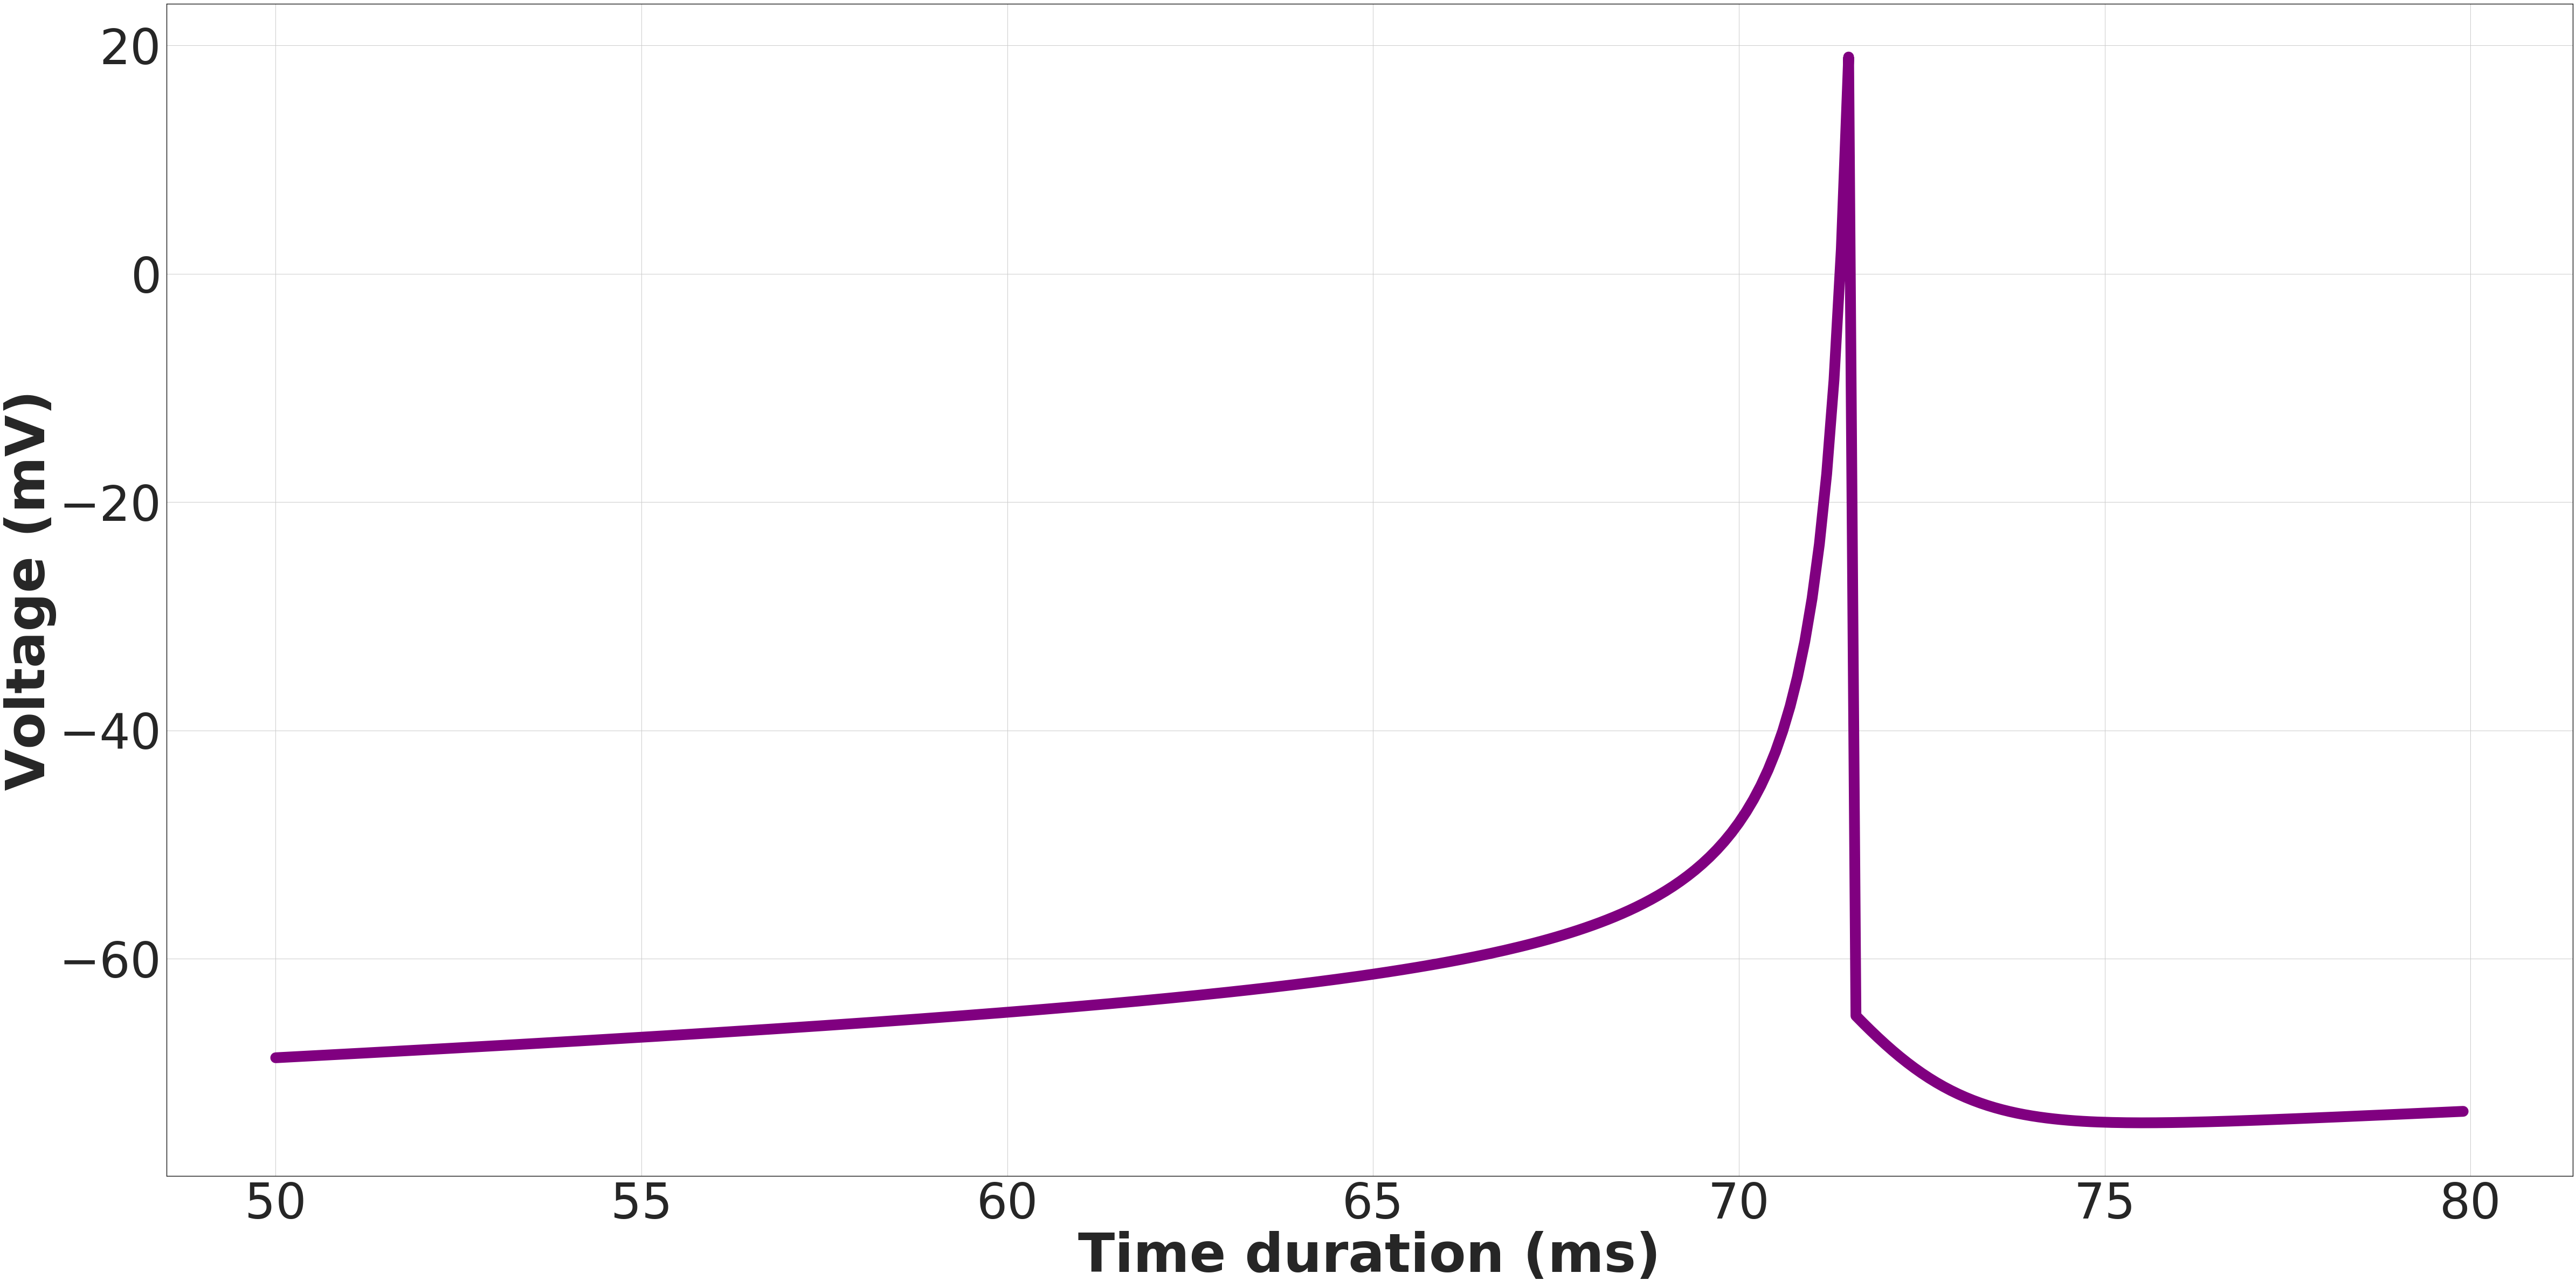

In [30]:
plt.rcParams['axes.edgecolor'] = "black" #set the value globally

fig,ax = plt.subplots(figsize=(80,40))

label_size = 100
ticks_size = 90
legend_size = 90
line_size = 20

neuron = 17

sns.lineplot(stateMon.t[500:800]/ms, stateMon.v[neuron][500:800]/mV, linewidth=line_size, color="purple")

ax.set_ylabel("Voltage (mV)", fontsize=label_size, fontweight="bold")
ax.tick_params(labelsize=ticks_size)
ax.set_xlabel("Time duration (ms)", fontsize=label_size, fontweight="bold")

#fig.savefig("differences_I.pdf")
#plt.close()

In [122]:
mon_trains = spikeMon.spike_trains()

In [139]:
third_spike = []

for i in range(0, 200):
    third_spike.append(mon_trains[i][2]/ms)

In [140]:
third_spike

[67.9,
 67.8,
 69.10000000000001,
 71.8,
 69.10000000000001,
 67.8,
 68.7,
 69.2,
 70.9,
 68.8,
 71.7,
 67.9,
 70.5,
 68.3,
 69.8,
 69.2,
 68.3,
 71.5,
 68.8,
 68.60000000000001,
 68.5,
 67.7,
 69.0,
 69.2,
 71.9,
 68.3,
 69.3,
 71.8,
 68.9,
 68.4,
 69.2,
 68.10000000000001,
 70.2,
 68.10000000000001,
 67.9,
 70.10000000000001,
 67.9,
 67.9,
 67.8,
 67.8,
 69.4,
 69.3,
 68.3,
 70.5,
 68.60000000000001,
 68.19999999999999,
 69.3,
 69.8,
 68.4,
 69.60000000000001,
 70.60000000000001,
 67.9,
 68.3,
 68.10000000000001,
 69.3,
 68.5,
 68.3,
 67.9,
 69.3,
 67.7,
 71.2,
 68.3,
 69.60000000000001,
 68.19999999999999,
 68.10000000000001,
 67.7,
 69.5,
 68.5,
 68.4,
 71.2,
 68.3,
 70.7,
 67.9,
 68.5,
 70.7,
 68.0,
 70.4,
 71.8,
 69.0,
 68.5,
 68.7,
 68.3,
 69.2,
 69.2,
 68.60000000000001,
 68.5,
 67.9,
 71.5,
 69.2,
 71.0,
 67.7,
 67.9,
 71.1,
 71.6,
 68.5,
 71.3,
 68.4,
 69.2,
 69.3,
 68.8,
 68.10000000000001,
 67.9,
 67.8,
 70.10000000000001,
 67.9,
 71.3,
 67.9,
 71.7,
 71.9,
 71.8,
 71.1,
 6

In [141]:
mean(third_spike)

69.0775

In [142]:
std(third_spike)

1.1842481792259587

In [ ]:
def dump_simulation_data_to_csv(attack, test, n_attacks, n_neurons, attacked_neurons, coord_attack, stim_value, n_exec, vIncrement, paramI, monitor, filename):
    mon_trains = monitor.spike_trains()
    
    for neuron in mon_trains.keys():
        for time_delta in mon_trains[neuron]:
            append_to_csv_file(filename, [attack, test, n_attacks, n_neurons, attacked_neurons, coord_attack, stim_value, n_exec, str(vIncrement), str(paramI), round(time_delta/ms, 1), neuron])

In [37]:
listNeurons = [0]
vIncrement = 10
paramI = 10
stimValue = 1.0
tAttacks = [67*mV]

In [38]:
spikeMon_a, stateMon_a = attack_simulation('JAM', False, 1*ms, tAttacks, stimValue, SIMULATION_TIME, listNeurons, vIncrement, paramI)

Text(0.5, 0, 'Time duration (ms)')

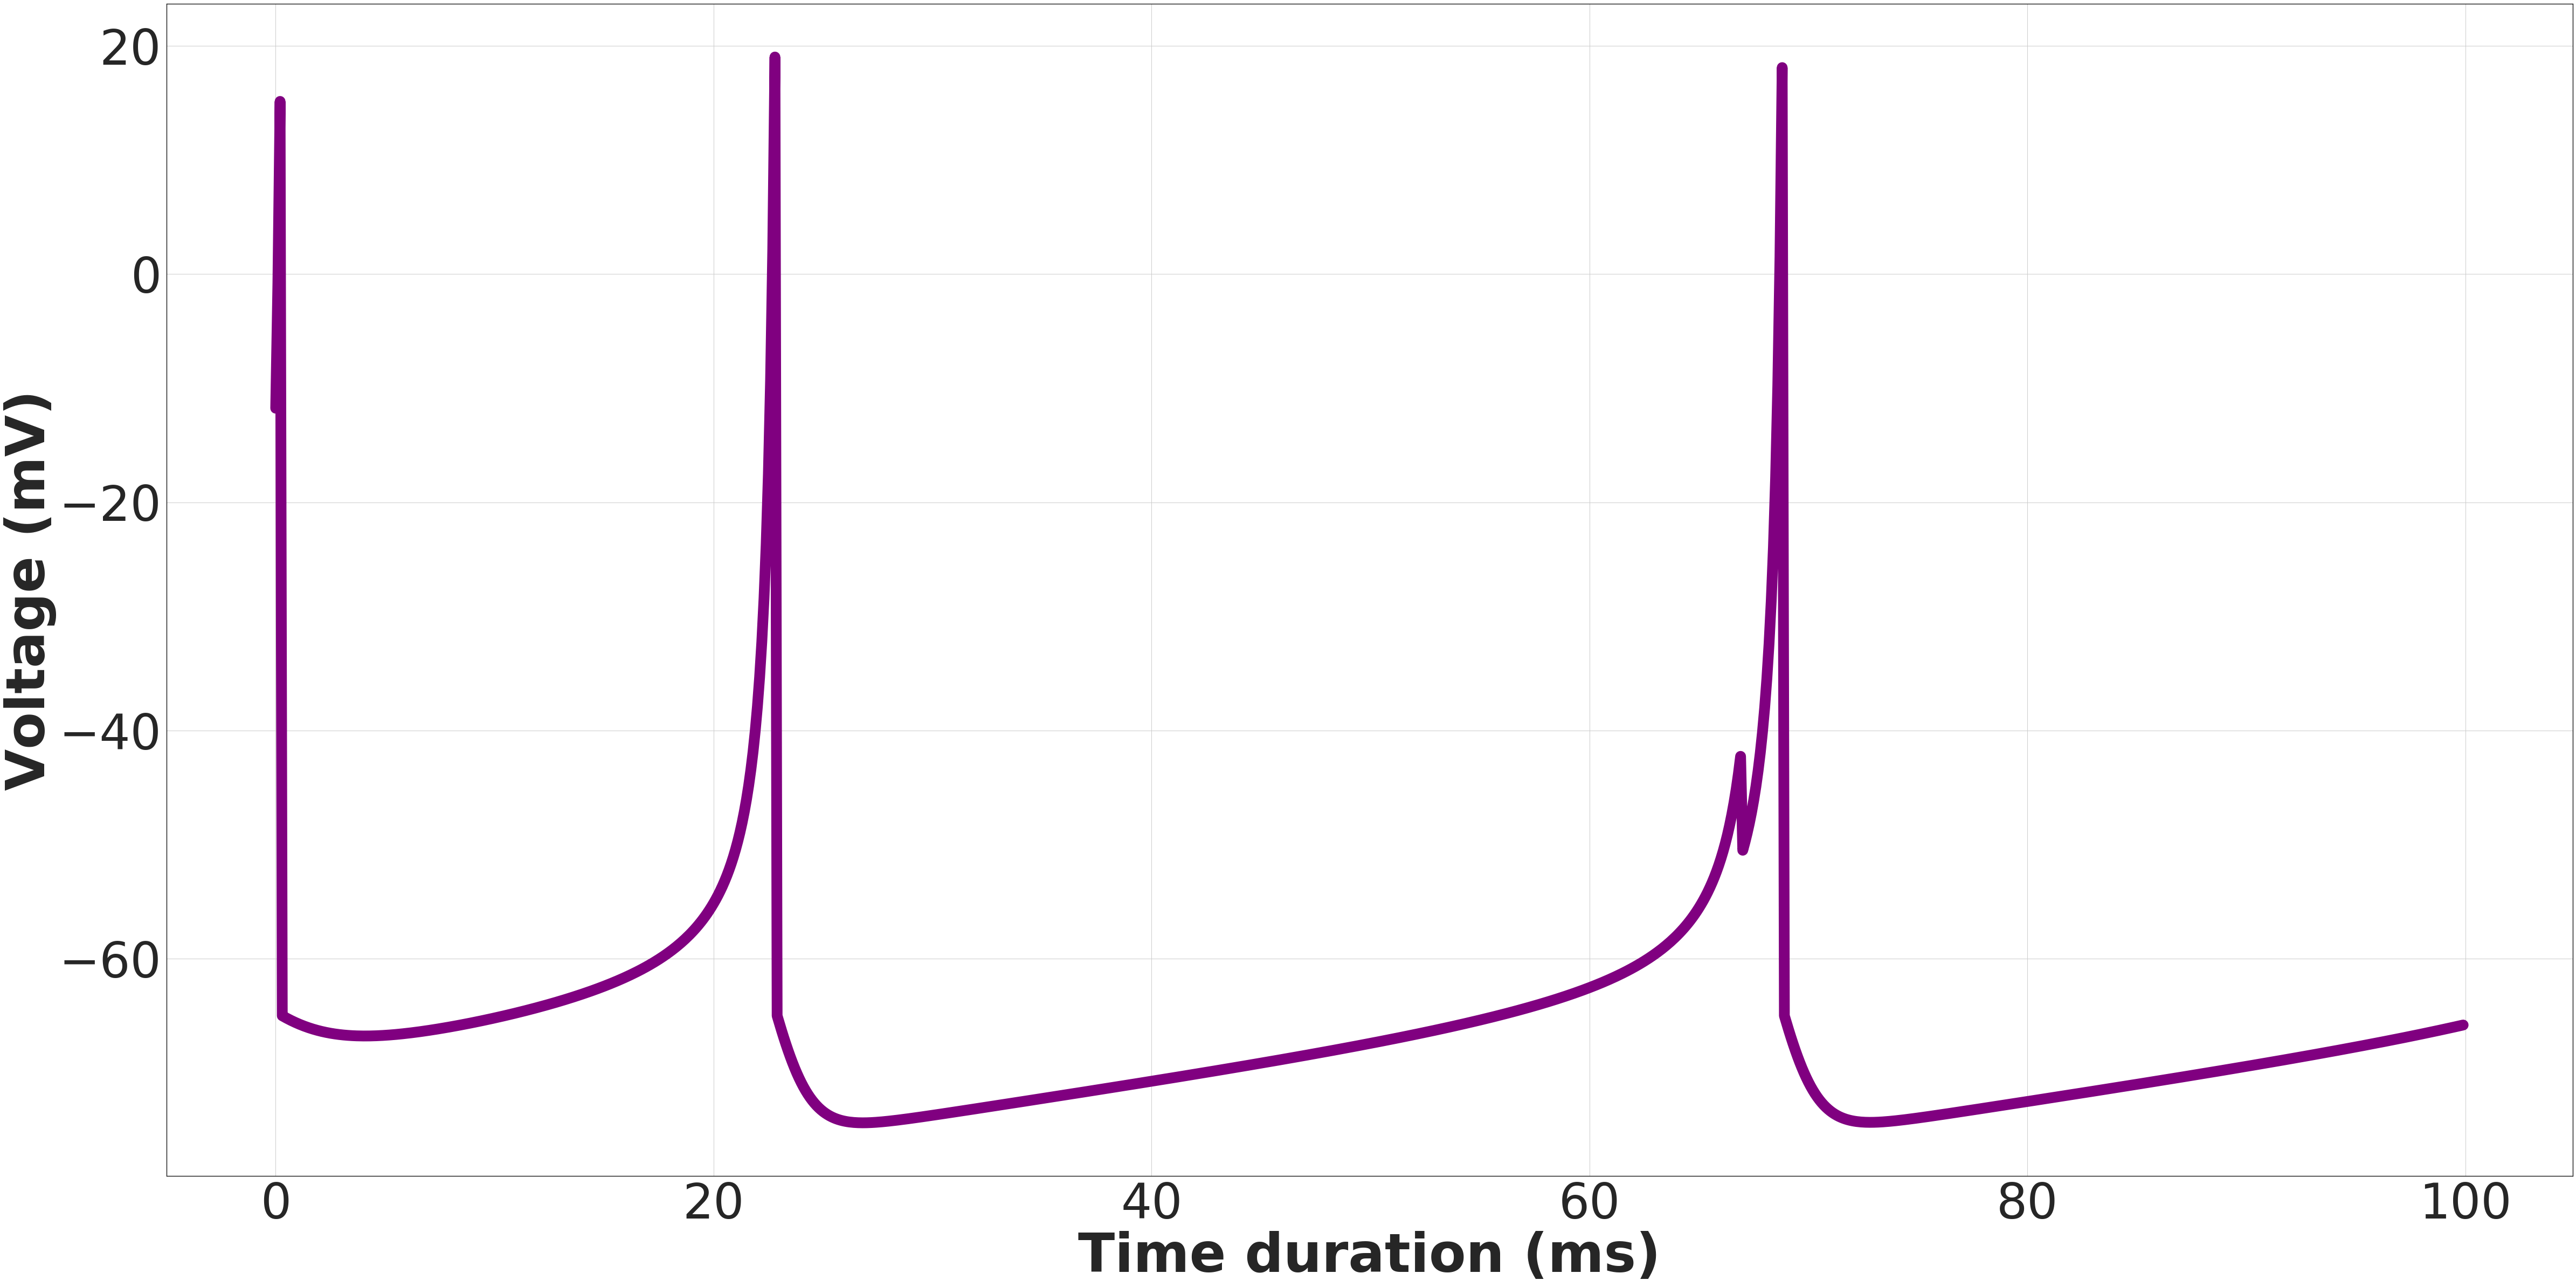

In [39]:
plt.rcParams['axes.edgecolor'] = "black" #set the value globally

fig,ax = plt.subplots(figsize=(80,40))

label_size = 100
ticks_size = 90
legend_size = 90
line_size = 20

neuron = 0

sns.lineplot(stateMon_a.t[:1000]/ms, stateMon_a.v[neuron][:1000]/mV, linewidth=line_size, color="purple")

ax.set_ylabel("Voltage (mV)", fontsize=label_size, fontweight="bold")
ax.tick_params(labelsize=ticks_size)
ax.set_xlabel("Time duration (ms)", fontsize=label_size, fontweight="bold")

#fig.savefig("differences_I.pdf")
#plt.close()

Text(0.5, 0, 'Time duration (ms)')

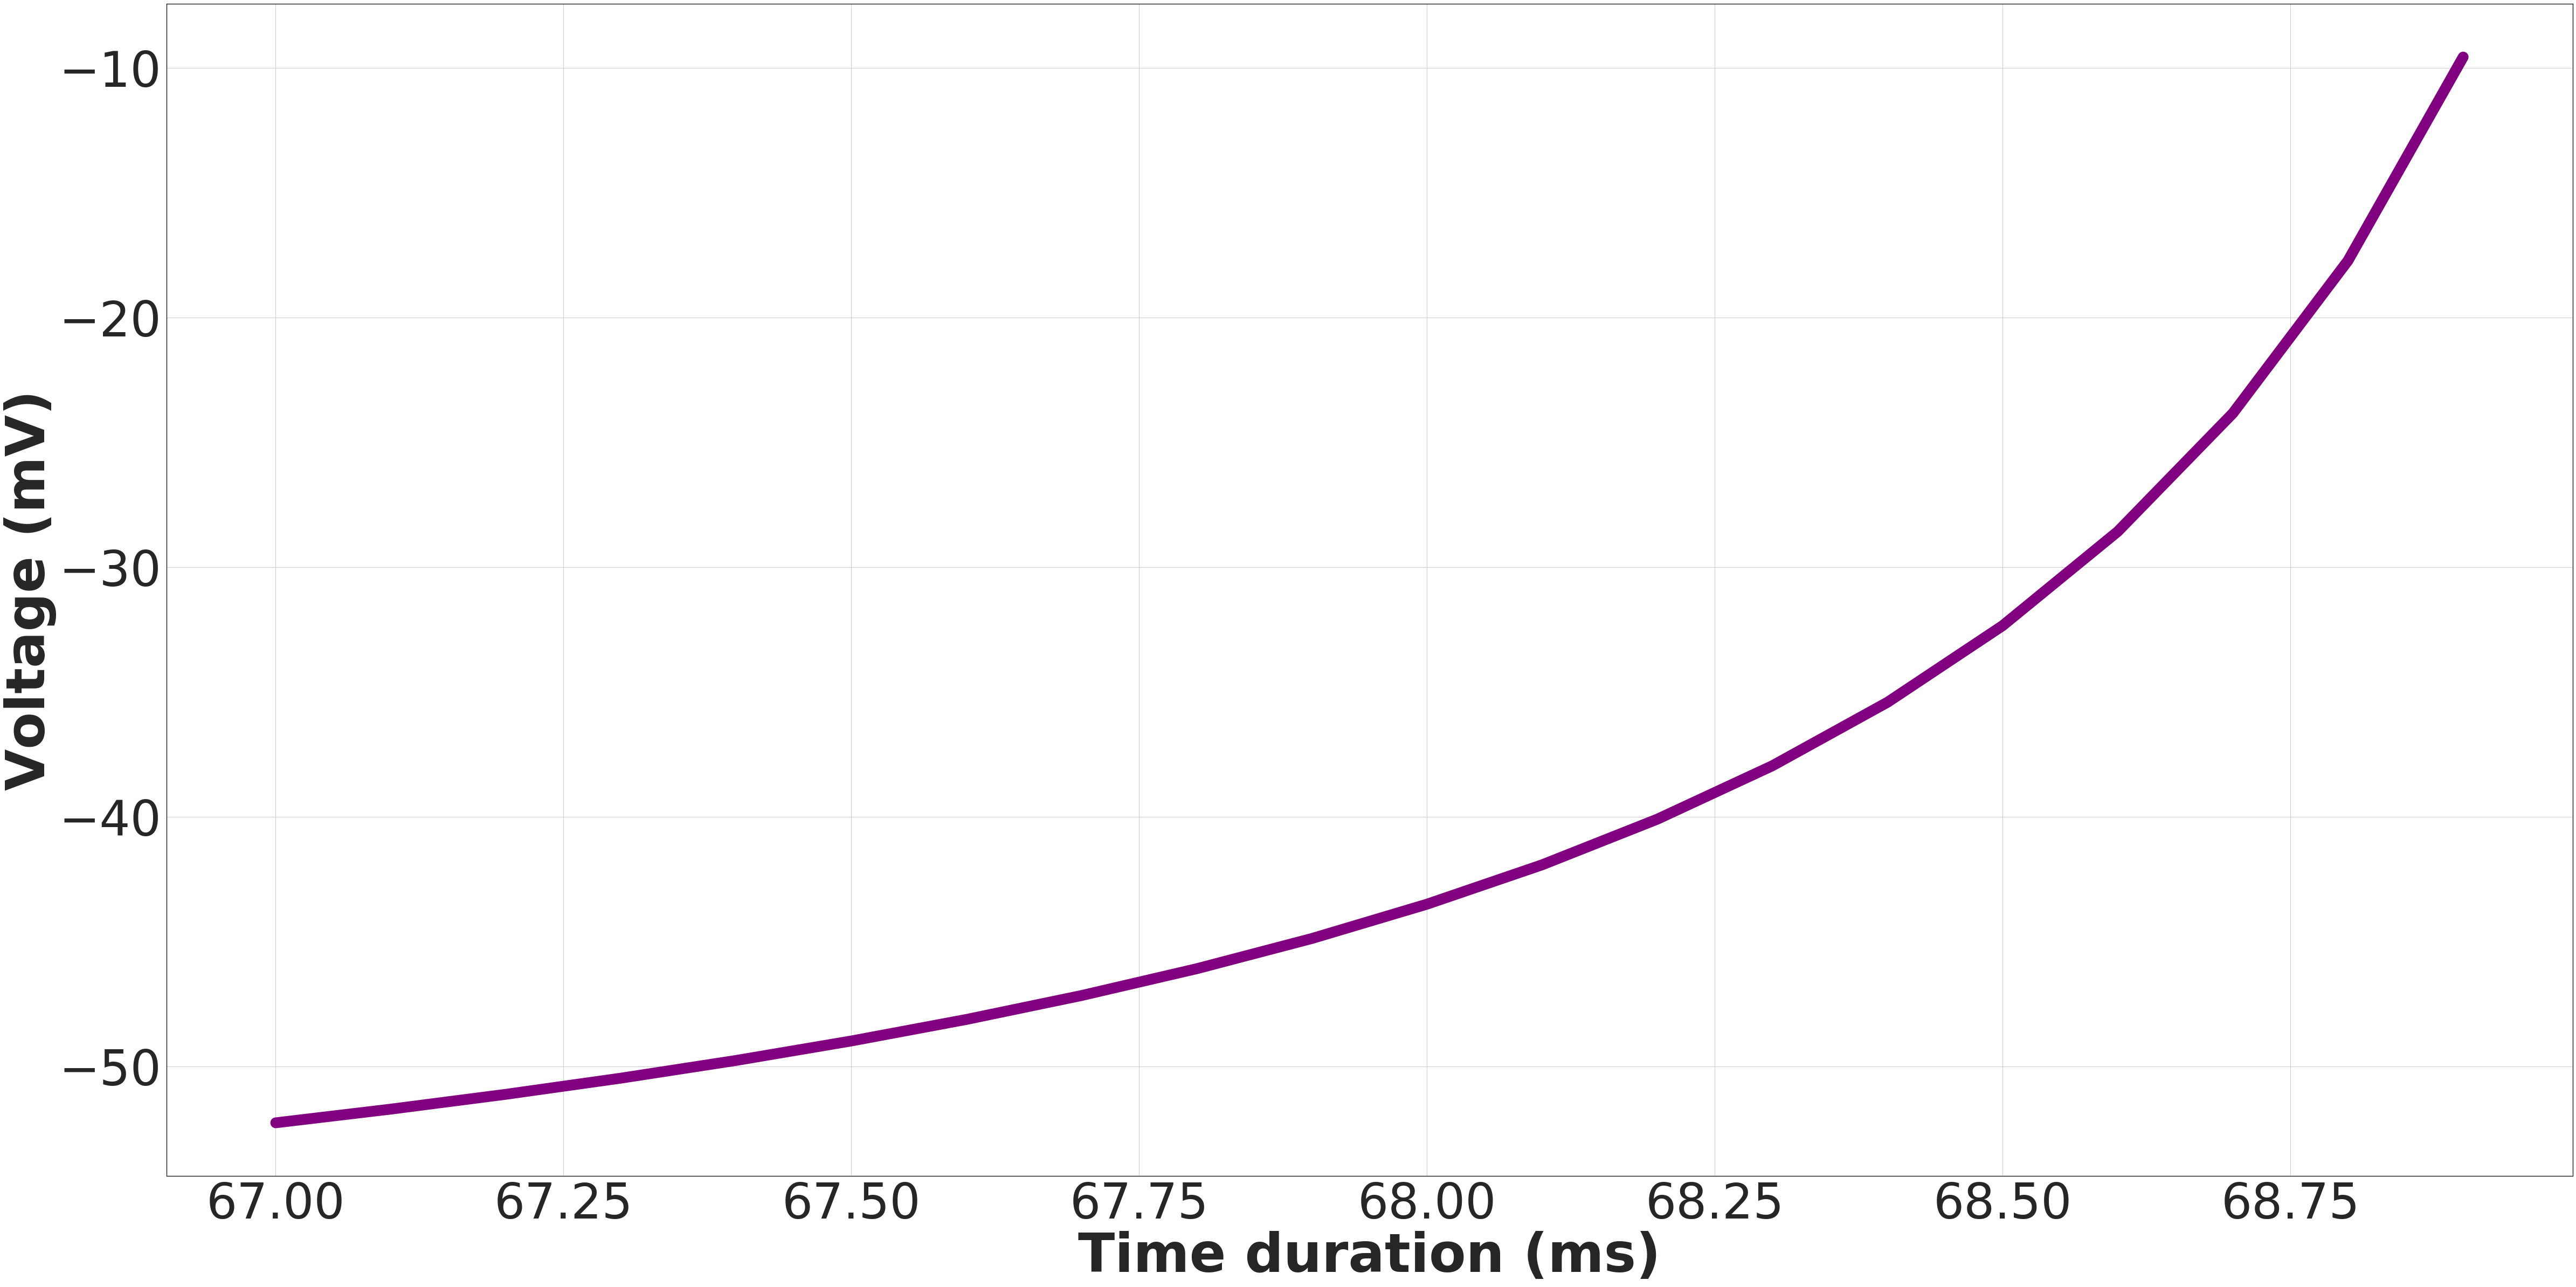

In [106]:
plt.rcParams['axes.edgecolor'] = "black" #set the value globally

fig,ax = plt.subplots(figsize=(80,40))

label_size = 100
ticks_size = 90
legend_size = 90
line_size = 20

neuron = 2

sns.lineplot(stateMon.t[670:690]/ms, stateMon.v[neuron][670:690]/mV, linewidth=line_size, color="purple")

ax.set_ylabel("Voltage (mV)", fontsize=label_size, fontweight="bold")
ax.tick_params(labelsize=ticks_size)
ax.set_xlabel("Time duration (ms)", fontsize=label_size, fontweight="bold")

#fig.savefig("differences_I.pdf")
#plt.close()